In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [ ]:
device = torch.device('cpu')
if (torch.cuda.is_available()):
    device = torch.device('cuda')

## HYPERPARAMS

In [ ]:
dataroot = '../storage/data/mnist_png/training/'
workers = 4
batch_size = 32
image_size = 784
nc = 1
nz = 100

num_epochs = 50
lr = 0.0002
momentum = 0.5
dampening = 0

k=1

## DATA

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=nc),
    torchvision.transforms.ToTensor(),
])

train_ds = torchvision.datasets.ImageFolder(dataroot, transforms)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=workers)
print('Length of dataset:',len(train_ds))

Length of dataset: 60000


Images shape: torch.Size([32, 1, 28, 28])


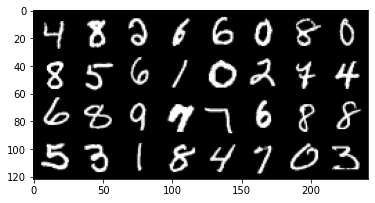

In [ ]:
for images, _ in train_dl:
    print('Images shape:',images.shape)
    plt.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1,2,0))
    break

## MODELS

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(nz , 256),
            nn.LeakyReLU(0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256 , 512),
            nn.LeakyReLU(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512 , 1024),
            nn.LeakyReLU(0.2),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(1024 , 784),
            nn.Tanh()
        )
        
    def forward(self, batch):
        #RECIEVES BATCH OF SIZE (batch_size, nz)
        batch = batch.view(batch.size(0), -1)
        out = self.fc1(batch)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(784 , 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024 , 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512 , 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256 , 1),
            nn.Sigmoid()
        )
        
    def forward(self, batch):
        #RECIEVES BATCH OF SIZE (batch_size, 784) or (batch_size, 1, 28, 28)
        batch = batch.view(batch.size(0), -1)
        out = self.fc1(batch)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

## LOSS FUNCTIONS

In [ ]:
opt_g = torch.optim.Adam(generator.parameters(), lr)
opt_d = torch.optim.Adam(discriminator.parameters(), lr)

criterion = nn.BCELoss()

## PRE-TRAIN FUNCTIONS

In [ ]:
real_labels = torch.ones(batch_size,1).to(device)
fake_labels = torch.zeros(batch_size,1).to(device)

In [ ]:
fixed_noise = torch.randn(batch_size, nz).to(device)

## PRE-TRAIN TEST

In [ ]:
sample = generator(fixed_noise).detach()
print("Generated Samples:", sample.shape)

sample_output = discriminator(sample).detach()
print("Sample Outputs:", sample_output.shape)

Generated Samples: torch.Size([32, 784])
Sample Outputs: torch.Size([32, 1])


## TRAIN

In [ ]:
start_time = time.time()

loss_d = []
loss_g = []

for epoch in range(num_epochs):
    loss_d_ = 0.0
    loss_g_ = 0.0
    for i, (images, _) in enumerate(train_dl):
        #DISCRIMINATOR
        opt_d.zero_grad()
        
        real_images = images.to(device)
        fake_images = generator(torch.randn(batch_size, nz).to(device)).detach()
        
        real_outputs = discriminator(real_images) 
        fake_outputs = discriminator(fake_images) 
        
        real_loss = criterion(real_outputs, real_labels)
        fake_loss = criterion(fake_outputs, fake_labels)
        real_loss.backward()
        fake_loss.backward()
        
        opt_d.step()
        
        loss_d_ += real_loss + fake_loss
        
        #GENERATOR
        opt_g.zero_grad()
        
        output = discriminator(generator(torch.randn(batch_size, nz).to(device)))
        
        loss = criterion(output, real_labels)
        loss.backward()
        
        opt_g.step()
        
        loss_g_ += loss
    
    epoch_loss_g = loss_g_/i
    epoch_loss_d = loss_d_/i
    loss_g.append(epoch_loss_g)
    loss_d.append(epoch_loss_d)
    print(f'{epoch}/{num_epochs} | Generator_Loss: {epoch_loss_g:.8f} | Discriminator_Loss: {epoch_loss_d:.8f} | Time Elapsed: {time.time() - start_time:.0f} seconds')
    
    if epoch%1==0:
        sample = generator(fixed_noise).detach()
        grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=8, pad_value=1, normalize=False)   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join('../storage/data/AS_storage/generatedImages', 'MNIST_VANILLA_GAN_{}.jpg'.format(str(epoch).zfill(3))))    
    
print(f'\nTOTAL DURATION: {time.time() - start_time:.0f} seconds')
sample = generator(fixed_noise).detach()
grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=8, pad_value=1, normalize=False)   
torchvision.utils.save_image(grid.detach().cpu(), os.path.join('../storage/data/AS_storage/generatedImages', 'MNIST_VANILLA_GAN_050.jpg'))    

0/50 | Generator_Loss: 1.83965504 | Discriminator_Loss: 1.01256752 | Time Elapsed: 26 seconds
1/50 | Generator_Loss: 2.06425476 | Discriminator_Loss: 0.77969086 | Time Elapsed: 47 seconds
2/50 | Generator_Loss: 2.08516669 | Discriminator_Loss: 0.78774768 | Time Elapsed: 67 seconds
3/50 | Generator_Loss: 2.13530469 | Discriminator_Loss: 0.71989846 | Time Elapsed: 86 seconds
4/50 | Generator_Loss: 2.22505522 | Discriminator_Loss: 0.68479133 | Time Elapsed: 106 seconds
5/50 | Generator_Loss: 2.18948078 | Discriminator_Loss: 0.69498456 | Time Elapsed: 125 seconds
6/50 | Generator_Loss: 2.35434580 | Discriminator_Loss: 0.62980133 | Time Elapsed: 145 seconds
7/50 | Generator_Loss: 2.41131353 | Discriminator_Loss: 0.60939872 | Time Elapsed: 165 seconds
8/50 | Generator_Loss: 2.64364672 | Discriminator_Loss: 0.55173504 | Time Elapsed: 184 seconds
9/50 | Generator_Loss: 2.76235127 | Discriminator_Loss: 0.53422052 | Time Elapsed: 204 seconds
10/50 | Generator_Loss: 2.84280562 | Discriminator_Los

## EVALUATION

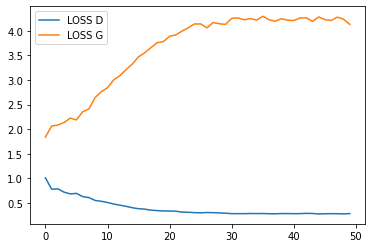

In [ ]:
plt.figure()

plt.plot(loss_d, label='LOSS D')
plt.plot(loss_g, label='LOSS G')
plt.legend()
plt.show()

## SAVING

In [ ]:
torch.save(generator.state_dict(), './mnist_vanilla_gan_generator.pt')
torch.save(discriminator.state_dict(), './mnist_vanilla_gan_discriminator.pt')

In [ ]:
# # LOAD MODEL
# discriminator.load_state_dict(torch.load('./mnist_vanilla_gan_discriminator.pt'))
# generator.load_state_dict(torch.load('./mnist_vanilla_gan_generator.pt'))